<a href="https://colab.research.google.com/github/egyvedriyanto78/Deep-Learning/blob/UAS_Kapsel_DeepL/Butterfly_MobileNetV2_by_EgyVedriyanto_2117051035.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eksperimen Model MobileNetV2 untuk klasifikasi Kupu-kupu yang terdiri dari 8 kelas
Egy Vedriyanto 2117051035

## Library

In [1]:
# Mengimpor library yang diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Mengecek apakah GPU tersedia untuk pelatihan
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset

In [2]:
# Mengimpor Google Drive untuk mengakses dataset
from google.colab import drive
drive.mount('/content/drive')

# Path ke dataset kupu-kupu di Google Drive
dataset_path = '/content/drive/My Drive/Computer Vision/butterfly_dataset'

Mounted at /content/drive


In [3]:
# Transformasi untuk train (augmentasi) dan test/validasi (tanpa augmentasi)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize untuk MobileNetV2
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_no_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path)

# Membagi dataset menjadi train, validation, dan test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Terapkan transformasi ke subset dataset
train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
val_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_no_augment)
test_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_no_augment)

# DataLoader untuk batch training
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset berhasil dimuat. Train: {train_size}, Val: {val_size}, Test: {test_size}")

Dataset berhasil dimuat. Train: 556, Val: 159, Test: 80


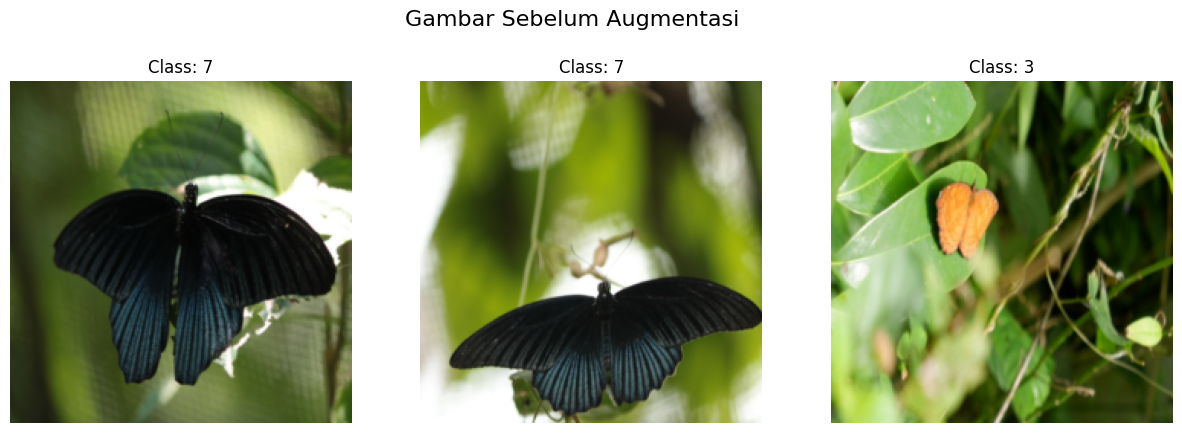

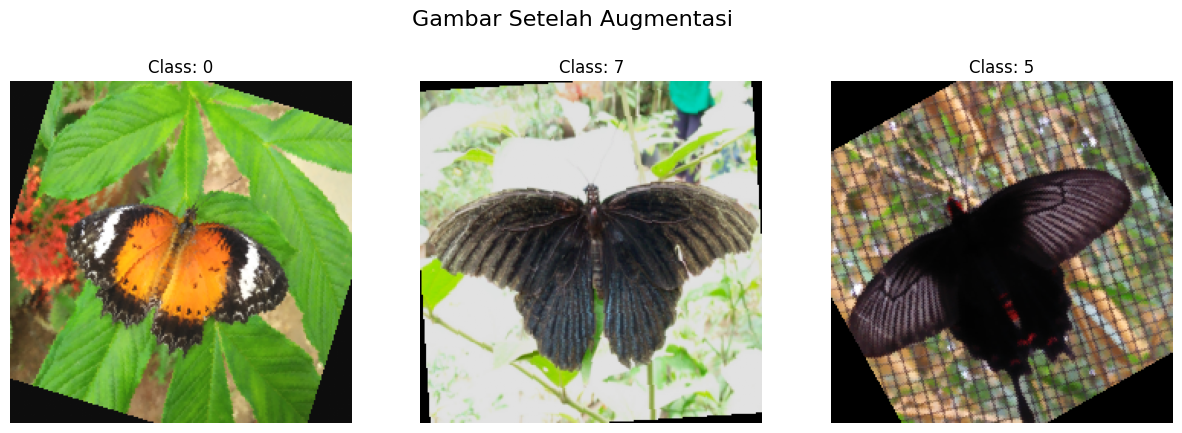

In [12]:
import random

# Fungsi untuk menampilkan gambar
def show_images(dataset, title, num_images=3):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i in range(num_images):
        # Pilih gambar acak dari dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]

        # Denormalisasi gambar
        img = img * 0.5 + 0.5  # Balikkan normalisasi ke rentang [0, 1]
        img = img.permute(1, 2, 0).numpy()  # Ubah tensor menjadi numpy array

        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"Class: {label}")
    plt.show()

# Menampilkan 3 gambar acak dari dataset sebelum augmentasi (transform_no_augment)
show_images(val_dataset.dataset, "Gambar Sebelum Augmentasi")

# Menampilkan 3 gambar acak dari dataset setelah augmentasi (transform_train)
show_images(train_dataset.dataset, "Gambar Setelah Augmentasi")

## Modeling

In [4]:
# Load MobileNetV2 dari torchvision dengan penyesuaian output
mobilenet = models.mobilenet_v2(pretrained=True)  # Pretrained weights pada ImageNet
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, len(dataset.classes))  # Penyesuaian output
mobilenet = mobilenet.to(device)

print(mobilenet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 146MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
# Menggunakan CrossEntropyLoss untuk klasifikasi multi-kelas
criterion = nn.CrossEntropyLoss()

# Optimizer menggunakan Adam
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

## Model Training

In [6]:
from torch.cuda.amp import autocast, GradScaler

# Inisialisasi scaler untuk menjaga stabilitas gradien
scaler = GradScaler()

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    """
    Melatih model dengan mixed precision menggunakan torch.cuda.amp
    Args:
        model: Model PyTorch yang akan dilatih
        train_loader: DataLoader untuk training
        val_loader: DataLoader untuk validation
        criterion: Loss function
        optimizer: Optimizer
        epochs: Jumlah epoch
    Returns:
        history: Dictionary berisi train_loss dan val_loss
    """
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validasi
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Mixed precision forward pass
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return history

<ipython-input-6-4f50893ae073>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [7]:
# Pelatihan model MobileNetV2
epochs = 20
history = train_model(mobilenet, train_loader, val_loader, criterion, optimizer, epochs)

<ipython-input-6-4f50893ae073>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-6-4f50893ae073>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20, Train Loss: 0.3960, Val Loss: 0.0135
Epoch 2/20, Train Loss: 0.1086, Val Loss: 0.0272
Epoch 3/20, Train Loss: 0.1279, Val Loss: 0.0903
Epoch 4/20, Train Loss: 0.1692, Val Loss: 0.0791
Epoch 5/20, Train Loss: 0.0733, Val Loss: 0.0015
Epoch 6/20, Train Loss: 0.1464, Val Loss: 0.0359
Epoch 7/20, Train Loss: 0.1907, Val Loss: 0.0055
Epoch 8/20, Train Loss: 0.0694, Val Loss: 0.0151
Epoch 9/20, Train Loss: 0.0463, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0283, Val Loss: 0.0006
Epoch 11/20, Train Loss: 0.0077, Val Loss: 0.0002
Epoch 12/20, Train Loss: 0.0790, Val Loss: 0.2022
Epoch 13/20, Train Loss: 0.1301, Val Loss: 0.1506
Epoch 14/20, Train Loss: 0.2572, Val Loss: 0.0524
Epoch 15/20, Train Loss: 0.0411, Val Loss: 0.0003
Epoch 16/20, Train Loss: 0.0213, Val Loss: 0.0002
Epoch 17/20, Train Loss: 0.0096, Val Loss: 0.0054
Epoch 18/20, Train Loss: 0.0124, Val Loss: 0.0000
Epoch 19/20, Train Loss: 0.0106, Val Loss: 0.0019
Epoch 20/20, Train Loss: 0.0045, Val Loss: 0.0000


## Model Evaluation

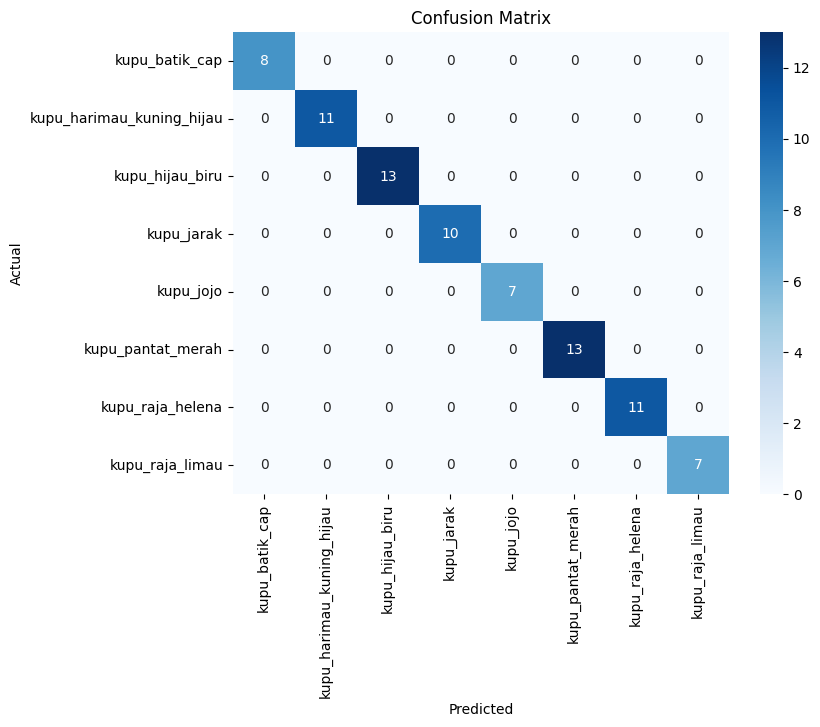

Classification Report:
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      1.00      1.00         8
kupu_harimau_kuning_hijau       1.00      1.00      1.00        11
          kupu_hijau_biru       1.00      1.00      1.00        13
               kupu_jarak       1.00      1.00      1.00        10
                kupu_jojo       1.00      1.00      1.00         7
        kupu_pantat_merah       1.00      1.00      1.00        13
         kupu_raja_helena       1.00      1.00      1.00        11
          kupu_raja_limau       1.00      1.00      1.00         7

                 accuracy                           1.00        80
                macro avg       1.00      1.00      1.00        80
             weighted avg       1.00      1.00      1.00        80



In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

y_true, y_pred = evaluate_model(mobilenet, test_loader)

# Confusion matrix dan classification report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=dataset.classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(report)

## Model Prediction

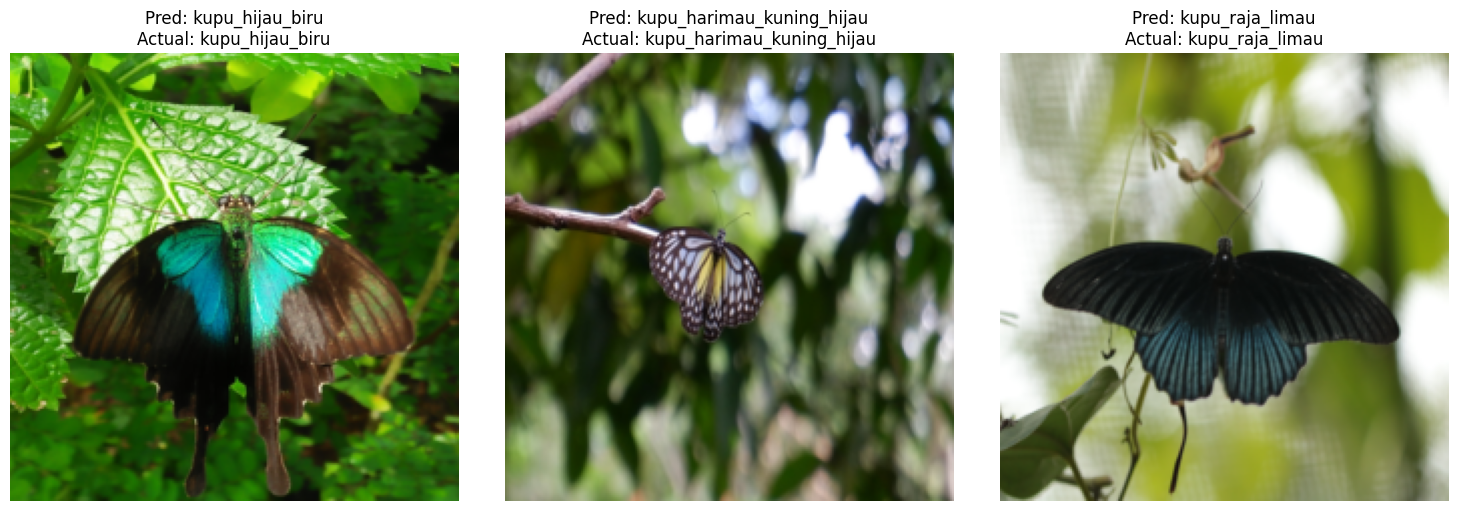

In [11]:
def show_predictions(model, dataset, class_names, num_images=3):
    """
    Menampilkan beberapa gambar dari dataset, prediksi model, dan label aktualnya.
    Args:
        model: Model PyTorch yang sudah dilatih.
        dataset: Dataset yang akan digunakan untuk menampilkan gambar.
        class_names: Daftar nama kelas sesuai urutan indeks label.
        num_images: Jumlah gambar yang akan ditampilkan.
    """
    model.eval()  # Set model ke mode evaluasi
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        idx = np.random.randint(len(dataset))  # Ambil indeks acak
        img, label = dataset[idx]  # Dapatkan gambar dan label
        img_tensor = img.unsqueeze(0).to(device)  # Tambahkan dimensi batch dan pindahkan ke GPU/CPU

        # Lakukan prediksi
        with torch.no_grad():
            output = model(img_tensor)  # Output model
            _, pred = torch.max(output, 1)  # Prediksi kelas

        # Denormalisasi gambar untuk ditampilkan
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalisasi dari normalisasi [-1, 1] ke [0, 1]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {class_names[pred.item()]}\nActual: {class_names[label]}")

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
class_names = test_dataset.dataset.classes  # Ambil nama kelas dari dataset
show_predictions(mobilenet, test_dataset, class_names, num_images=3)